## Cleaning Regional Dengue Clusters Data

In [1]:
import pandas as pd
import numpy as np
import glob
import geopandas as gpd
import fiona

import datetime

from sklearn.impute import SimpleImputer

fiona.drvsupport.supported_drivers['libkml'] = 'rw' # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw' # enable KML support which is disabled by default

## Read in Planning Area File

Read in as GeoDataFrame

In [2]:
planning_area = gpd.read_file('../datasets/dengue_cases_regional/planning-boundary-area.kml')

<Axes: >

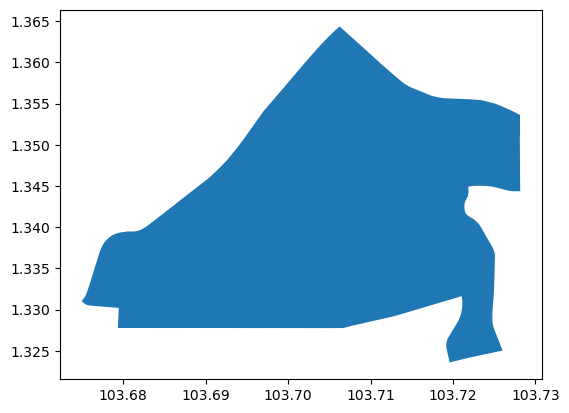

In [3]:
planning_area[planning_area['PLN_AREA_N']=='JURONG WEST'].plot()

In [4]:
# convert polygon shape into point
planning_area['centroid'] = planning_area['geometry'].centroid

C:\Users\fishe\AppData\Local\Temp\ipykernel_308\3320127830.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  planning_area['centroid'] = planning_area['geometry'].centroid


## Read in Dengue Clusters Files

Read in each file and append into single file, then convert to GeoDataFrame

In [5]:
dengue_cluster_filelist = glob.glob('../datasets/dengue_cases_regional/*-clusters.csv')

df = []

for file in dengue_cluster_filelist:

    temp = pd.read_csv(file, names=['num_of_cases', 
                                  'street_address', 
                                  'latitude', 
                                  'longitude', 
                                  'cluster_num', 
                                  'recent_cases_in_cluster', 
                                  'total_cases_in_cluster',
                                  'date',
                                  'month'])
    df.append(temp)
    
df = pd.concat(df, ignore_index=True)

### Data Dictionary

| | |
|----|----|
|Number Of Cases|Number of reported dengue cases at this location |
|Street Address|Street address where dengue cases are reported (down to the apartment block level) |
|Latitude|Latitude of the street address |
|Longitude|Longitude of the street address |
|Cluster Number|Every dengue cluster is labelled with a serial number. However, this serial number cannot be used as an unique identifier because (1) the serial number is reused in other snapshots and (2) the serial number will change throughout the cluster's lifetime. |
|Recent Cases In Cluster**|Number of dengue cases with onset in the last 2 weeks |
|Total Cases In Cluster| Total number of dengue cases reported in this cluster |
|Date|Date string in YYMMDD format |
|Month Number|Index number of the month, where 1=January and 12=December |

In [6]:
df.info()
# Observation: no null values, need to convert date to datetime dtype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56976 entries, 0 to 56975
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   num_of_cases             56976 non-null  int64  
 1   street_address           56976 non-null  object 
 2   latitude                 56976 non-null  float64
 3   longitude                56976 non-null  float64
 4   cluster_num              56976 non-null  int64  
 5   recent_cases_in_cluster  56976 non-null  int64  
 6   total_cases_in_cluster   56976 non-null  int64  
 7   date                     56976 non-null  int64  
 8   month                    56976 non-null  int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 3.9+ MB


In [7]:
df.describe()

,num_of_cases,latitude,longitude,cluster_num,recent_cases_in_cluster,total_cases_in_cluster,date,month
count,56976.000000,56976.000000,56976.000000,56976.000000,56976.000000,56976.000000,56976.000000,56976.000000
mean,2.583667,1.354812,103.856974,35.301425,6.346462,37.508688,183041.102868,6.426390
std,3.931250,0.038571,0.064542,47.190155,7.331141,54.091489,18159.408902,3.248549
min,1.000000,1.264626,103.614371,1.000000,1.000000,2.000000,150703.000000,1.000000
25%,1.000000,1.323170,103.829118,6.000000,2.000000,4.000000,160613.000000,4.000000
50%,1.000000,1.350902,103.868549,18.000000,4.000000,14.000000,190808.000000,7.000000
75%,3.000000,1.375948,103.903538,47.000000,8.000000,48.000000,200306.000000,9.000000
max,104.000000,1.466968,103.973141,393.000000,92.000000,381.000000,201106.000000,12.000000


In [8]:
# convert date to datetime dtype
df['date'] = pd.to_datetime(df['date'], format='%y%m%d')

In [9]:
# check which ones are sundays
df['date'].dt.dayofweek.value_counts()

4    29459
0    15918
1     6648
2     2551
3     2400
Name: date, dtype: int64

In [10]:
# check out case distribution by weekdays
df['weekday'] = df['date'].dt.dayofweek
df.groupby('weekday').describe()

num_of_cases                                                latitude  \
               count      mean       std  min  25%  50%  75%    max    count   
weekday                                                                        
0            15918.0  2.269632  3.551776  1.0  1.0  1.0  2.0   82.0  15918.0   
1             6648.0  2.258875  3.012523  1.0  1.0  1.0  2.0   82.0   6648.0   
2             2551.0  2.490004  3.740058  1.0  1.0  1.0  3.0   82.0   2551.0   
3             2400.0  2.627917  3.857979  1.0  1.0  1.0  3.0   57.0   2400.0   
4            29459.0  2.831155  4.297069  1.0  1.0  1.0  3.0  104.0  29459.0   

                   ... total_cases_in_cluster           month            \
             mean  ...                    75%    max    count      mean   
weekday            ...                                                    
0        1.355413  ...                   30.0  278.0  15918.0  6.169808   
1        1.355216  ...                   36.0  255.0   6648.0  4.962996   
2        1.361350  ...                   48.0  276.0   2551.0  4.905527   
3        1.356709  ...                   39.0  186.0   2400.0  6.418333   
4        1.353675  ...                   61.0  381.0  29459.0  7.027632   

                                             
              std  min  25%  50%  75%   max  
weekday                                      
0        3.636288  1.0  3.0  6.0  9.0  12.0  
1        2.747344  1.0  3.0  5.0  7.0  12.0  
2        1.917538  2.0  2.0  6.0  6.0   8.0  
3        1.975675  1.0  4.0  8.0  8.0   9.0  
4        3.137877  1.0  5.0  8.0  9.0  12.0  

[5 rows x 56 columns]

Observation:

- Data is not aligned to sunday of the week, need to impute.

In [11]:
# create geometry column
df['geometry'] = gpd.points_from_xy(x=df['longitude'], y=df['latitude'])

# convert to GeoDataFrame
df = gpd.GeoDataFrame(df)
df.set_crs(epsg=4326, inplace=True)

,num_of_cases,street_address,latitude,longitude,cluster_num,recent_cases_in_cluster,total_cases_in_cluster,date,month,weekday,geometry
0,4,bishan street 22 (block 232),1.358286,103.845226,1,24,83,2015-07-03,7,4,POINT (103.84523 1.35829)
1,7,bishan street 22 (block 233),1.358639,103.845259,1,24,83,2015-07-03,7,4,POINT (103.84526 1.35864)
2,3,bishan street 22 (block 234),1.358390,103.845955,1,24,83,2015-07-03,7,4,POINT (103.84596 1.35839)
3,1,bishan street 22 (block 235),1.358719,103.846477,1,24,83,2015-07-03,7,4,POINT (103.84648 1.35872)
4,4,bishan street 22 (block 236),1.359041,103.846849,1,24,83,2015-07-03,7,4,POINT (103.84685 1.35904)
...,...,...,...,...,...,...,...,...,...,...,...
56971,1,tampines street 71 (block 715),1.359660,103.937074,131,2,2,2020-11-06,11,4,POINT (103.93707 1.35966)
56972,1,tampines street 71 (block 716),1.359482,103.936586,131,2,2,2020-11-06,11,4,POINT (103.93659 1.35948)
56973,1,tampines street 82 (block 842b),1.351145,103.936991,132,2,2,2020-11-06,11,4,POINT (103.93699 1.35115)
56974,1,tampines street 82 (block 842e),1.351754,103.938303,132,2,2,2020-11-06,11,4,POINT (103.93830 1.35175)


In [12]:
jdf = gpd.sjoin(df, planning_area, how='left')

In [13]:
jdf.head(50)

,num_of_cases,street_address,latitude,longitude,cluster_num,recent_cases_in_cluster,total_cases_in_cluster,date,month,weekday,...,icon,PLN_AREA_N,PLN_AREA_C,CA_IND,REGION_N,REGION_C,INC_CRC,FMEL_UPD_D,snippet,centroid
0,4,bishan street 22 (block 232),1.358286,103.845226,1,24,83,2015-07-03,7,4,...,NaN,BISHAN,BS,N,CENTRAL REGION,CR,F06B9400ED89EF69,20191206144714,,POINT (103.84044 1.35496)
1,7,bishan street 22 (block 233),1.358639,103.845259,1,24,83,2015-07-03,7,4,...,NaN,BISHAN,BS,N,CENTRAL REGION,CR,F06B9400ED89EF69,20191206144714,,POINT (103.84044 1.35496)
2,3,bishan street 22 (block 234),1.358390,103.845955,1,24,83,2015-07-03,7,4,...,NaN,BISHAN,BS,N,CENTRAL REGION,CR,F06B9400ED89EF69,20191206144714,,POINT (103.84044 1.35496)
3,1,bishan street 22 (block 235),1.358719,103.846477,1,24,83,2015-07-03,7,4,...,NaN,BISHAN,BS,N,CENTRAL REGION,CR,F06B9400ED89EF69,20191206144714,,POINT (103.84044 1.35496)
4,4,bishan street 22 (block 236),1.359041,103.846849,1,24,83,2015-07-03,7,4,...,NaN,BISHAN,BS,N,CENTRAL REGION,CR,F06B9400ED89EF69,20191206144714,,POINT (103.84044 1.35496)
5,1,bishan street 22 (block 237),1.359335,103.847097,1,24,83,2015-07-03,7,4,...,NaN,BISHAN,BS,N,CENTRAL REGION,CR,F06B9400ED89EF69,20191206144714,,POINT (103.84044 1.35496)
6,2,bishan street 22 (block 293),1.356245,103.845879,1,24,83,2015-07-03,7,4,...,NaN,BISHAN,BS,N,CENTRAL REGION,CR,F06B9400ED89EF69,20191206144714,,POINT (103.84044 1.35496)
7,2,bishan street 23 (block 220),1.357568,103.848743,1,24,83,2015-07-03,7,4,...,NaN,BISHAN,BS,N,CENTRAL REGION,CR,F06B9400ED89EF69,20191206144714,,POINT (103.84044 1.35496)
8,1,bishan street 23 (block 222),1.358069,103.848079,1,24,83,2015-07-03,7,4,...,NaN,BISHAN,BS,N,CENTRAL REGION,CR,F06B9400ED89EF69,20191206144714,,POINT (103.84044 1.35496)
9,5,bishan street 23 (block 223),1.358557,103.848049,1,24,83,2015-07-03,7,4,...,NaN,BISHAN,BS,N,CENTRAL REGION,CR,F06B9400ED89EF69,20191206144714,,POINT (103.84044 1.35496)


In [14]:
jdf.columns

Index(['num_of_cases', 'street_address', 'latitude', 'longitude',
       'cluster_num', 'recent_cases_in_cluster', 'total_cases_in_cluster',
       'date', 'month', 'weekday', 'geometry', 'index_right', 'Name',
       'description', 'timestamp', 'begin', 'end', 'altitudeMode',
       'tessellate', 'extrude', 'visibility', 'drawOrder', 'icon',
       'PLN_AREA_N', 'PLN_AREA_C', 'CA_IND', 'REGION_N', 'REGION_C', 'INC_CRC',
       'FMEL_UPD_D', 'snippet', 'centroid'],
      dtype='object')

In [15]:
# extract only needed columns
jdf = jdf[['cluster_num',
           'recent_cases_in_cluster',
           'date', 'REGION_N', 'centroid']]

## Aggregate Data by Date and Regions

In [16]:
# aggregate at cluster level
jdf = jdf.groupby(['date', 'cluster_num']).agg({'recent_cases_in_cluster': 'mean', 'REGION_N':'first', 'centroid':'first'}).reset_index()

# aggregate to region level
dengue_clusters_by_region = jdf.groupby(['date', 'REGION_N']).sum(numeric_only=True).reset_index()

# pivot data to create one datapoint per date (only keep num_of_cases and recent_cases)
dengue_clusters_by_region = dengue_clusters_by_region.pivot(index='date', columns='REGION_N', values=['recent_cases_in_cluster'])

# create full list of dates and reindex dataframe
dates = pd.date_range(start=dengue_clusters_by_region.index[0], end=dengue_clusters_by_region.index[-1], freq='D')
dengue_clusters_by_region = dengue_clusters_by_region.reindex(dates)

In [17]:
# impute missing data for total_cases
dengue_clusters_by_region['recent_cases_in_cluster'] = dengue_clusters_by_region['recent_cases_in_cluster'].interpolate(method='slinear').round(0)

In [18]:
# extract only the sunday figures
dengue_clusters_by_region = dengue_clusters_by_region[dengue_clusters_by_region.index.weekday == 6]

In [31]:
# save planning area centroids to file
regions = jdf.groupby('REGION_N').agg({'centroid':'first'}).reset_index()

# rename column from centroid to geometry for easier plotting in geopandas later on
regions.columns = ['REGION_N', 'geometry']

regions.to_csv('../datasets/regions.csv', index=False)

In [19]:
# rename index to 'date'
dengue_clusters_by_region.rename_axis('date', inplace=True)

# flatten columns
dengue_clusters_by_region.columns = [f"{i}_{j.split(' ')[0].lower()}" for i, j in dengue_clusters_by_region.columns]

# save to file
dengue_clusters_by_region.to_csv('../datasets/dengue_clusters_by_region.csv', index=True)

## Unused code for Planning Area

In [155]:
dengue_clusters_by_planningarea = jdf.groupby(['date', 'PLN_AREA_N']).sum(numeric_only=True)

In [156]:
dengue_clusters_by_planningarea.drop(columns=['latitude', 'longitude', 'cluster_num'], inplace=True)

In [157]:
dengue_clusters_by_planningarea.to_csv('../datasets/dengue_clusters_by_planningarea.csv', index=False)

In [238]:
def interpolate_recent_cases(df):
    
    for i in df.index:
        #for region in range(5):
            
            #print(row['recent_cases_in_cluster'][region])
            
            # test if recent_cases is alredy filled, if not filled, then run the interpolation
            #if not np.isnan(row['recent_cases_in_cluster'][region]):
        try: # try-except structure to catch cases where the interpolation data is unavailable
            # recent_cases will be interpolated by adding the current latest cases minus off the latest cases from 2 weeks ago
           
            cases_today = df.loc[i, 'num_of_cases']
            recent_cases_yest = df.loc[i-datetime.timedelta(days=1), 'recent_cases_in_cluster']
            cases_2weeksback = df.loc[i-datetime.timedelta(days=14), 'num_of_cases']
            
            df.loc[i, 'recent_cases_in_cluster'] = (recent_cases_yest + cases_today - cases_2weeksback).apply(lambda x: max(x,0)).values

        except: # except clause to return null, so the recent_cases will remain NaN
            pass
                
    return df